In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [2]:
from cpymad.madx import Madx

import sixtracklib as pyst

In [3]:
import h5py

In [4]:
from scipy.constants import e, m_p, c, epsilon_0

In [5]:
import sys, os
sys.path = ["/home/oeftiger/gsi/git/python3/PyHEADTAIL/", 
            "/home/oeftiger/gsi/git/"] + sys.path

import pickle

In [6]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

from pycuda.driver import memcpy_dtod_async

In [7]:
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.general import pmath as pm
from PyHEADTAIL.particles.generators import (
    generate_Gaussian6DTwiss, gaussian2D, 
    cut_distribution, make_is_accepted_within_n_sigma)

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.pypic_factory import create_3dmesh_from_beam, create_mesh
from PyHEADTAIL.spacecharge.pypic_spacecharge import (
    SpaceChargePIC, SpaceChargePIC_Adaptive25D)

from PyHEADTAIL.monitors.monitors import BunchMonitor, ParticleMonitor

from PyHEADTAIL.general.contextmanager import GPU

from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.13.5




/home/oeftiger/anaconda3/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


PyPIC v2.4.2
Info: cusolver_Rf not found. GPU finite difference solver not available.


In [8]:
from PyPIC.GPU.poisson_solver.FFT_solver import (
    GPUFFTPoissonSolver_2_5D, GPUFFTPoissonSolver)
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

In [9]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', 'np.asscalar')

In [10]:
import PyNAFF as pnf
from tune_diagram import ResonanceLines

In [11]:
nmass = 0.931494061 # MAD-X value

In [12]:
n_macroparticles = int(1e6)
n_slices_sc = 64
n_scnodes = 500

# fixed field map for space charge
n_mesh_nodes = 256
n_mesh_sigma = 24

intensity = 0.625e11
eps4g_x = 35e-6 # 4x geometrical RMS emittances
eps4g_y = 15e-6
A = 238 # atomic units
Q = 28 # charge units

number_cavities = 14
harmonic = 10
sigma_z = 58 / 4. # in m
sigma_dp = 1e-15 #0.5e-3

Ekin_per_nucleon = 0.2e9 # in eV

Qx = 18.84
Qy = 18.73

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)
epsn_x = beta * gamma * eps4g_x / 4
epsn_y = beta * gamma * eps4g_y / 4
# beta_z = 1 #np.abs(eta) * circumference / (2 * np.pi * Qs)
beta_z = sigma_z / sigma_dp
epsn_z = sigma_z * sigma_dp * 4 * np.pi * p0 / e # sigma_z**2 * 4 * np.pi * p0 / (e * beta_z)

In [13]:
Etot == 238 * 0.2 + 238 * nmass

True

# Preparing the lattice in MAD-X

In [14]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.08.22 13:54:50      +
  ++++++++++++++++++++++++++++++++++++++++++++


## set up basic lattice

In [15]:
madxwarn = madx.options.warn
madx.options.warn = False
madx.call('./SIS100_RF_220618_9slices.thin.seq')
madx.options.warn = madxwarn

In [16]:
madx.command.beam(particle='ion', mass=A * nmass, charge=Q, energy=Etot)

True

In [17]:
madxinfo = madx.options.info
madx.options.info = False
madx.call('OpticsYEH_BeamParameters.str')
madx.options.info = madxinfo

++++++ warning: ignored: attempt to redefine constant: lqd


In [18]:
madx.use(sequence='sis100ring')

In [19]:
madx.input('''
    select, flag=seqedit, class=collimator;
    
    select, flag=seqedit, class=hmonitor;
    select, flag=seqedit, class=vmonitor;
    select, flag=seqedit, class=kicker;
    select, flag=seqedit, class=tkicker;
    select, flag=seqedit, class=dipedge;
    select, flag=seqedit, class=elseparator;

    seqedit, sequence=SIS100RING;
        remove, element=selected;
        flatten;
    endedit;

    select, flag=seqedit, class=marker;
    seqedit, sequence=SIS100RING;
        remove, element=selected;
        install, element=SIS100RING$START, s=0;
        flatten;
    endedit;
''')

madx.use(sequence='sis100ring')

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    1631
++++++ info: seqedit - number of elements replaced:   0
++++++ warning: ignored, unknown command or element: (null)
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    272
++++++ info: seqedit - number of elements replaced:   0


In [20]:
madx.input('''
    match, sequence=SIS100RING;
    global, sequence=SIS100RING, q1={qx}, q2={qy};
    vary, name=kqf, step=0.00001;
    vary, name=kqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qx=Qx, qy=Qy)
)

START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   1.59751935e-14





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80434e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.80405e-01 -2.80616e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   1.59751935e-14


True

In [21]:
# madx.input('''
# number_cavities = {0};
# cavity_voltage = 58.2/1000/number_cavities*{1};'''.format(number_cavities, Q))

In [22]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004028605417        15.75515332 

                q1                dq1            betxmax              dxmax 
       18.83999999       -39.71149243        20.00746672        3.057630947 

             dxrms             xcomax             xcorms                 q2 
       1.355022577                  0                  0        18.73000001 

               dq2            betymax              dymax              dyrms 
      -39.80669472         21.2553155                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [23]:
circumference = twiss.summary.length
assert circumference == twiss['s'][-1]

## add SC nodes

In [24]:
l_target = circumference / n_scnodes
l_fuzz = l_target / 2.

l_target

2.1672

In [25]:
madx.input('sc_placeholder: Marker;')

True

In [26]:
madx.command.seqedit(sequence='SIS100RING')

True

In [27]:
# remove FODO$start marker, otherwise this space charge node would have 0 length
for i in range(1, len(twiss['name'])):
    el_name = twiss['name'][i]
    s = twiss['s'][i]
    l = twiss['l'][i]
    if not 'drift' in el_name:
        madx.command.install(element='sc_placeholder', at=s)
    else:
        if l < l_target + l_fuzz:
            continue
        l_remaining = l
        s_insert = s - l
        while l_remaining > l_target:
            s_insert += l_target
            madx.command.install(element='sc_placeholder', at=s_insert)
            l_remaining -= l_target

In [28]:
madx.command.flatten()

True

In [29]:
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  1936
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [30]:
madx.use(sequence='SIS100RING')
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004028605417        15.75515332 

                q1                dq1            betxmax              dxmax 
       18.83999999       -39.71149243        20.00746672        3.057630947 

             dxrms             xcomax             xcorms                 q2 
       1.336582183                  0                  0        18.73000001 

               dq2            betymax              dymax              dyrms 
      -39.80669472         21.2553155                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

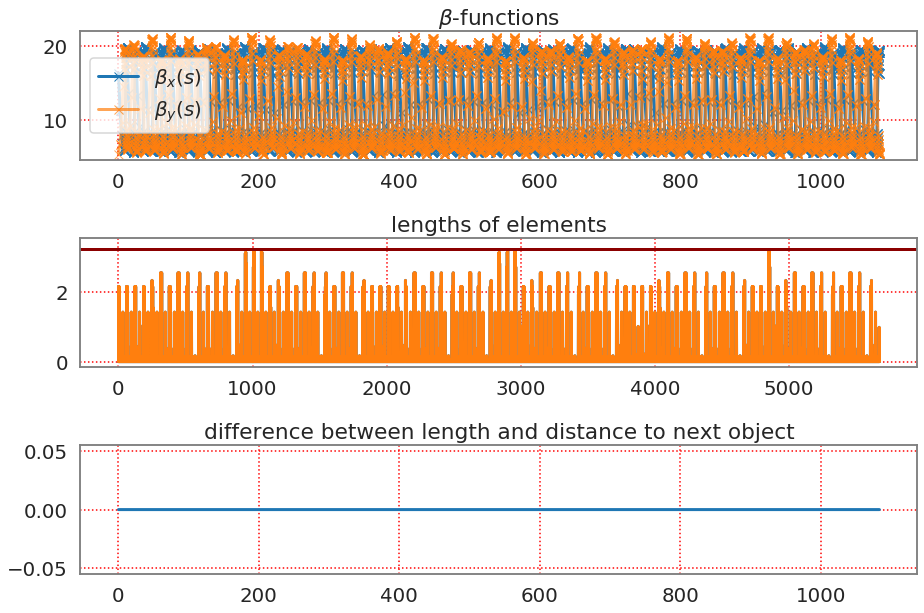

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))

plt.sca(ax[0])
plt.title(r'$\beta$-functions')
plt.plot(twiss['s'], twiss['betx'], marker='x', label=r'$\beta_x(s)$')
plt.plot(twiss['s'], twiss['bety'], marker='x', label=r'$\beta_y(s)$', alpha=0.7)
plt.legend()

plt.sca(ax[1])
plt.title('lengths of elements')
plt.plot(np.diff(twiss['s']))
plt.plot(twiss['l'][1:])
plt.axhline(l_target*1.5, color='darkred')
plt.ylim(top=l_target*1.5*1.1)

plt.sca(ax[2])
plt.title('difference between length and distance to next object')
plt.plot(twiss['s'][:-1], np.diff(twiss['s']) - twiss['l'][1:])

plt.subplots_adjust(hspace=0.6)

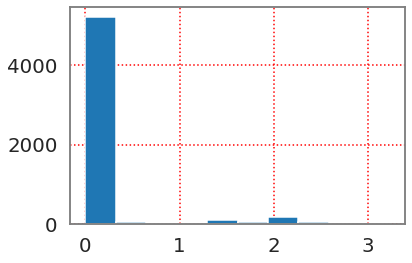

In [32]:
n, _, _ = plt.hist(twiss['l'], bins=10);
# assert n[0] - 1 == np.sum(n[1:])

# Preparing SixTrackLib for GPU:

In [33]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c, q0=28, mass0=238*nmass*1e9)

In [34]:
elements = pyst.Elements.from_mad(madx.sequence.sis100ring, exact_drift=True)

In [35]:
idx_mad_sc = [i for i, name in enumerate(madx.sequence.sis100ring.element_names()) 
              if 'sc_placeholder' in name]
sc_optics = {
    'beta_x': twiss['betx'][idx_mad_sc],
    'beta_y': twiss['bety'][idx_mad_sc],
    'D_x': twiss['dx'][idx_mad_sc],
    'D_y': twiss['dy'][idx_mad_sc],
    'x': twiss['x'][idx_mad_sc],
    'y': twiss['y'][idx_mad_sc],
    's': twiss['s'][idx_mad_sc]
}

In [36]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

# Preparing PyHEADTAIL beam

In [37]:
rf_voltage = [f for f in elements.get_elements() 
              if isinstance(f, pyst.Cavity)][0].voltage * number_cavities # in V

eta = twiss.summary['gammatr']**-2 - gamma**-2

In [38]:
x_co = twiss['x'][0]
y_co = twiss['y'][0]
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta
Dp_x_0 = twiss['dpx'][0] * beta
Dp_y_0 = twiss['dpy'][0] * beta

In [39]:
np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    n_macroparticles, intensity, charge, mass, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    beta_z, epsn_x, epsn_y, epsn_z,
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
    limit_n_rms_x=3.4**2, limit_n_rms_y=3.4**2, #limit_n_rms_z=3.4**2,
)

distribution_z_uncut = gaussian2D(sigma_z**2)
is_accepted = make_is_accepted_within_n_sigma(
    epsn_rms=sigma_z,
    limit_n_rms=3.4,
)
distribution_z_cut = cut_distribution(distribution_z_uncut, is_accepted)

z, dp = distribution_z_cut(n_macroparticles)
pyht_beam.z, pyht_beam.dp = z, dp / beta_z

# PyHT generates around 0, need to offset with closed orbit:
pyht_beam.x += x_co
pyht_beam.y += y_co

# PyHT only matches dispersive contribution to coordinate,
# need to add D'_{x,y} to momenta:
pyht_beam.xp += Dp_x_0 * pyht_beam.dp
pyht_beam.yp += Dp_y_0 * pyht_beam.dp

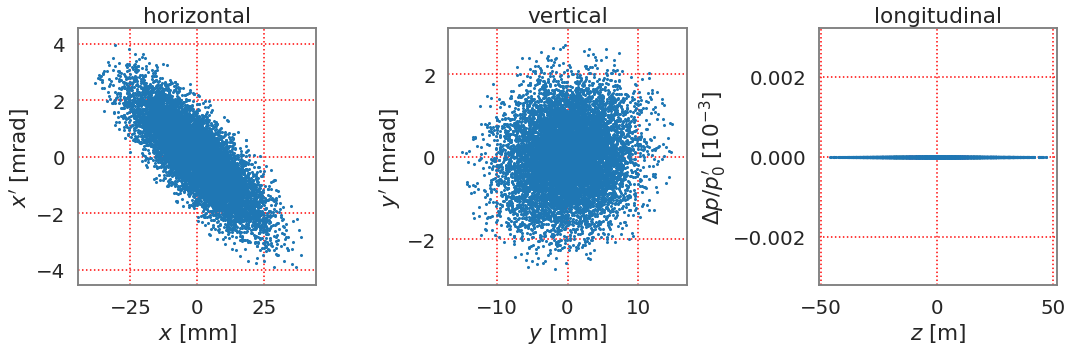

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal')
plt.scatter(pyht_beam.x[::100] * 1e3, pyht_beam.xp[::100] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.x.min() * 1e3, 1.1*pyht_beam.x.max() * 1e3)
plt.ylim(1.1*pyht_beam.xp.min() * 1e3, 1.1*pyht_beam.xp.max() * 1e3)
plt.xlabel('$x$ [mm]')
plt.ylabel("$x'$ [mrad]")

# plt.axvline(pyht_beam.sigma_x(), color='red')
# plt.axvline(2*pyht_beam.sigma_x(), color='red')
# plt.axvline(3*pyht_beam.sigma_x(), color='red')
# plt.axvline(3.4*pyht_beam.sigma_x(), color='red')

# ep = mpl.patches.Ellipse(
#     (0, 0), 2*pyht_beam.sigma_x() * 1e3, 2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 2*2*pyht_beam.sigma_x() * 1e3, 2*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 3*2*pyht_beam.sigma_x() * 1e3, 3*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 3.4*2*pyht_beam.sigma_x() * 1e3, 3.4*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='solid')
# plt.gca().add_patch(ep)

plt.sca(ax[1])
plt.title('vertical')
plt.scatter(pyht_beam.y[::100] * 1e3, pyht_beam.yp[::100] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.y.min() * 1e3, 1.1*pyht_beam.y.max() * 1e3)
plt.ylim(1.1*pyht_beam.yp.min() * 1e3, 1.1*pyht_beam.yp.max() * 1e3)
plt.xlabel('$y$ [mm]')
plt.ylabel("$y'$ [mrad]")

plt.sca(ax[2])
plt.title('longitudinal')
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100] * 1e3, s=10, marker='.')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0'$ [$10^{-3}$]")
plt.tight_layout()

plt.savefig('particle_generation_phasespaces.png', dpi=150, bbox_inches='tight')

# Interface to PyHEADTAIL

In [41]:
from pycuda import cumath

In [42]:
def provide_pycuda_array(ptr):
    return gp.GPUArray(n_macroparticles, dtype=np.float64, gpudata=ptr)

In [43]:
class TrackSixTrackLib(Element):
    '''General state.'''
    trackjob = None
    pointers = {}
    context = None
    n_elements = 0

    def __init__(self, trackjob, i_start, i_end, context=context):
        if TrackSixTrackLib.trackjob is None:
            TrackSixTrackLib.trackjob = trackjob

            trackjob.fetch_particle_addresses()
            assert trackjob.last_status_success
            ptr = trackjob.get_particle_addresses() # particleset==0 is default

            TrackSixTrackLib.pointers.update({
                'x': provide_pycuda_array(ptr.contents.x),
                'px': provide_pycuda_array(ptr.contents.px),
                'y': provide_pycuda_array(ptr.contents.y),
                'py': provide_pycuda_array(ptr.contents.py),
                'z': provide_pycuda_array(ptr.contents.zeta),
                'delta': provide_pycuda_array(ptr.contents.delta),
                'rpp': provide_pycuda_array(ptr.contents.rpp),
                'psigma': provide_pycuda_array(ptr.contents.psigma),
                'rvv': provide_pycuda_array(ptr.contents.rvv),
            })
            TrackSixTrackLib.n_elements = len(trackjob.beam_elements_buffer.get_elements())

        self.i_start = i_start
        self.i_end = i_end
        self.is_last_element = (i_end == self.n_elements)

        self.context = context

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        trackjob.track_line(self.i_start, self.i_end, 
                            finish_turn=self.is_last_element)
        # to be replaced by barrier:
        trackjob.collectParticlesAddresses()

        assert trackjob.last_track_status_success
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        self.memcpy(self.pointers['x'], beam.x)
        self.memcpy(self.pointers['px'], beam.xp)
        self.memcpy(self.pointers['y'], beam.y)
        self.memcpy(self.pointers['py'], beam.yp)
        self.memcpy(self.pointers['z'], beam.z)
        self.memcpy(self.pointers['delta'], beam.dp)
        
        # further longitudinal coordinates of SixTrackLib
        rpp = 1. / (beam.dp + 1)
        self.memcpy(self.pointers['rpp'], rpp)

        restmass = beam.mass * c**2
        restmass_sq = restmass**2
        E0 = np.sqrt((beam.p0 * c)**2 + restmass_sq)
        p = beam.p0 * (1 + beam.dp)
        E = cumath.sqrt((p * c) * (p * c) + restmass_sq)
        psigma =  (E - E0) / (beam.beta * beam.p0 * c)
        self.memcpy(self.pointers['psigma'], psigma)
                    
        gamma = E / restmass
        beta = cumath.sqrt(1 - 1. / (gamma * gamma))
        rvv = beta / beam.beta
        self.memcpy(self.pointers['rvv'], rvv)
        
        self.context.synchronize()

    @staticmethod
    def memcpy(dest, src):
        '''device memory copy with pycuda from src GPUArray to dest GPUArray.'''
#         dest[:] = src
#         memcpy_atoa(dest, 0, src, 0, len(src))
        memcpy_dtod_async(dest.gpudata, src.gpudata, src.nbytes)

    def stlib_to_pyht(self, beam):
        beam.x = self.pointers['x']
        beam.xp = self.pointers['px']
        beam.y = self.pointers['y']
        beam.yp = self.pointers['py']
        beam.z = self.pointers['z']
        beam.dp = self.pointers['delta']

# Prepare PyHEADTAIL style one-turn map

In [44]:
def rms_beam_size(beta_optics, epsn, disp_optics, 
                  sigma_dp=pyht_beam.sigma_dp(), beta=beta, gamma=gamma):
    return np.sqrt(beta_optics * epsn / (beta * gamma) + (disp_optics * sigma_dp)**2)

In [45]:
sig_x = rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).max()
sig_y = rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).max()

In [46]:
print ('The smallest horizontal beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_x - rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).min()) / sig_x * 100))

print ('The smallest vertical beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_y - rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).min()) / sig_y * 100))

The smallest horizontal beam size is 47.01% smaller than the largest beam size.
The smallest vertical beam size is 49.80% smaller than the largest beam size.


In [47]:
slicer_sc = UniformBinSlicer(n_slices_sc, n_sigma_z=4)

In [48]:
slices = pyht_beam.get_slices(slicer_sc)
assert not any(slices.particles_outside_cuts)

In [49]:
mesh_origin = [-n_mesh_sigma * sig_x, 
               -n_mesh_sigma * sig_y]
mesh_distances = [2 * n_mesh_sigma * sig_x / n_mesh_nodes, 
                  2 * n_mesh_sigma * sig_y / n_mesh_nodes]
mesh_3d = create_mesh(mesh_origin, mesh_distances, [n_mesh_nodes]*2, slices=slices)

In [50]:
poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
# poissonsolver = GPUFFTPoissonSolver(mesh_3d, context=context)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)

In [51]:
assert circumference == sum(
    el.length for el in elements.get_elements() 
    if isinstance(el, pyst.DriftExact)), \
    'SixTrackLib lattice element lengths do not sum up to circumference'

Assemble the one turn map with interleaved `PySixTrackLib` single-particle tracking and `PyHEADTAIL` space charge nodes:

In [52]:
one_turn_map = []

relevant_elements = elements.get_elements()

if isinstance(elements.get_elements()[-1], pyst.BeamMonitor):
    relevant_elements = relevant_elements[:-1]

i_last = 0
length_covered = 0
for i_curr, el in enumerate(relevant_elements):
    if not isinstance(el, pyst.DriftExact):
        continue
    length_covered += el.length

    #i_curr == 0 or 
    if el.length != 0 : # only inject SC node at markers (for SC)
        continue

    pyst_node = TrackSixTrackLib(trackjob, i_last, i_curr + 1, context=context)
    one_turn_map.append(pyst_node)

    sc_node = SpaceChargePIC(length_covered, pypic_algorithm)
    one_turn_map.append(sc_node)

    i_last = i_curr
    length_covered = 0

assert pyst_node.i_end == len(relevant_elements)
assert el._offset == relevant_elements[-1]._offset
assert isinstance(el, pyst.DriftExact)
assert el.length == 0

pyst_node.is_last_element = True

# Tracking space charge and full optics:

In [53]:
alpha_x = twiss['alfx'][0]
beta_x = twiss['betx'][0]
alpha_y = twiss['alfy'][0]
beta_y = twiss['bety'][0]

In [54]:
def get_action(u, up, dp=None, alpha_twiss=0, beta_twiss=1, disp=0):
    if disp and dp.any():
        u = u - disp * dp
    gamma_twiss = (1 + alpha_twiss**2) / beta_twiss
    J = 0.5 * (gamma_twiss * u**2 + 2*alpha_twiss * u * up + beta_twiss * up**2)
    return J

In [55]:
import PyHEADTAIL.gpu.thrust_interface as thrust

def gpu_sort(ary):
    sortd = ary.copy() # thrust sorts in place
    thrust.sort_double(sortd)
    return sortd

pm._CPU_numpy_func_dict['sort'] = np.sort
pm._GPU_func_dict['sort'] = gpu_sort

pm.update_active_dict(pm._CPU_numpy_func_dict)

In [56]:
J_quantiles = np.arange(0, 1, 0.05) + 0.05

J_quantiles_ids = list((J_quantiles * n_macroparticles).astype(int) - 1)

def get_J_xy_quantiles(
        pyht_beam, J_quantiles_ids=J_quantiles_ids, 
        alpha_x=alpha_x, alpha_y=alpha_y, 
        beta_x=beta_x, beta_y=beta_y):    
    J_x = get_action(pyht_beam.x, pyht_beam.xp, alpha_twiss=alpha_x, beta_twiss=beta_x)
    J_x_quantiles = pm.ensure_CPU(pm.sort(J_x))[J_quantiles_ids]

    J_y = get_action(pyht_beam.y, pyht_beam.yp, alpha_twiss=alpha_y, beta_twiss=beta_y)
    J_y_quantiles = pm.ensure_CPU(pm.sort(J_y))[J_quantiles_ids]
    return J_x_quantiles, J_y_quantiles

## tracking loop

Let's track:

In [57]:
n_turns = 128 - 1 #5000 #
n_stored_particles = 1000

bunchmon = BunchMonitor('bunchmonitor', n_turns + 1, write_buffer_every=1)
partmon = ParticleMonitor('particlemonitor', stride=n_macroparticles // n_stored_particles)

# emittance quantiles evolution
rec_epsn_q_x = np.empty((n_turns + 1, len(J_quantiles)), dtype=float)
rec_epsn_q_y = np.empty_like(rec_epsn_q_x)

J_x, J_y = get_J_xy_quantiles(pyht_beam)
rec_epsn_q_x[0, :] = beta * gamma * J_x
rec_epsn_q_y[0, :] = beta * gamma * J_y

with GPU(pyht_beam):
    bunchmon.dump(pyht_beam)
    partmon.dump(pyht_beam)

    for i in range(1, n_turns+1):
        for m in one_turn_map:
            m.track(pyht_beam)

        bunchmon.dump(pyht_beam)
        
        pyht_beam.sort_for('id')
        partmon.dump(pyht_beam)

        J_x, J_y = get_J_xy_quantiles(pyht_beam)
        rec_epsn_q_x[i, :] = beta * gamma * J_x
        rec_epsn_q_y[i, :] = beta * gamma * J_y
        
        sys.stdout.write('\rTurn {}/{}'.format(i, n_turns))

Turn 127/127

## saving

In [58]:
pickle.dump(pyht_beam, open('SIS_100_beam.p', 'wb'))

In [59]:
np.save('results_epsn_quantiles_x', rec_epsn_q_x)
np.save('results_epsn_quantiles_y', rec_epsn_q_y)

## preparing evaluation

In [60]:
with h5py.File('particlemonitor.h5part', 'r') as fp:
    n_steps = len([st for st in fp.keys() if 'Step' in st])
    n_stored_particles = len(fp['Step#0']['x'])
    
    rec_inc_x = np.empty((n_steps, n_stored_particles), dtype=np.float32)
    rec_inc_xp = np.empty_like(rec_inc_x)
    rec_inc_y = np.empty_like(rec_inc_x)
    rec_inc_yp = np.empty_like(rec_inc_x)
    rec_inc_z = np.empty_like(rec_inc_x)
    rec_inc_dp = np.empty_like(rec_inc_x)
    
    for i in range(n_steps):
        rec_inc_x[i, :] = fp['Step#{}'.format(i)]['x']
        rec_inc_xp[i, :] = fp['Step#{}'.format(i)]['xp']
        rec_inc_y[i, :] = fp['Step#{}'.format(i)]['y']
        rec_inc_yp[i, :] = fp['Step#{}'.format(i)]['yp']
        rec_inc_z[i, :] = fp['Step#{}'.format(i)]['z']
        rec_inc_dp[i, :] = fp['Step#{}'.format(i)]['dp']

In [61]:
with h5py.File('bunchmonitor.h5', 'r') as fb:
    rec_mean_x = np.array(fb['Bunch']['mean_x'])
    rec_mean_y = np.array(fb['Bunch']['mean_y'])
    rec_epsn_x = np.array(fb['Bunch']['epsn_x'])
    rec_epsn_y = np.array(fb['Bunch']['epsn_y'])

In [62]:
rec_epsn100_x = rec_epsn_q_x[:, -1]
rec_epsn100_y = rec_epsn_q_y[:, -1]

# evaluation

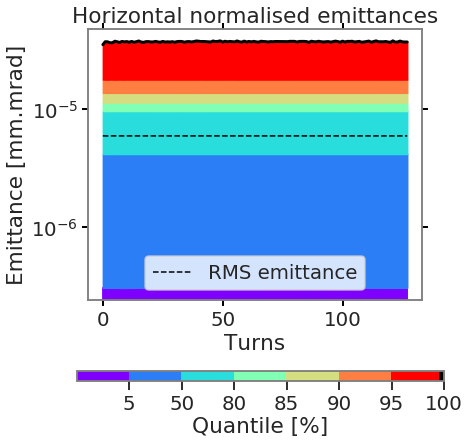

In [19]:
J_chosen_ids = [0, 9, 15, 16, 17, 18, 19]

NUM_COLORS = len(J_chosen_ids)
cm = plt.get_cmap('rainbow')

i_cgen = [cm(1.*i/float(NUM_COLORS - 1)) for i in range(NUM_COLORS)]

plt.figure(figsize=(6, 5))

last_J_idx = J_chosen_ids[0]
plt.fill_between(np.arange(len(rec_epsn_q_x)),
                 0,
                 rec_epsn_q_x[:, last_J_idx],
                 color=i_cgen[0])

for J_idx, col in zip(J_chosen_ids[1:], i_cgen[1:]):
    plt.fill_between(np.arange(len(rec_epsn_q_x)),
                     rec_epsn_q_x[:, last_J_idx],
                     rec_epsn_q_x[:, J_idx],
                     color=col)
    last_J_idx = J_idx

plt.plot(rec_epsn_q_x[:, last_J_idx], color='black')

plt.plot(rec_epsn_x, color='black', ls='--', lw=1.5, label='RMS emittance')
plt.legend(loc=8)

plt.yscale('log')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='none')

plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Horizontal normalised emittances')

cmap = cm.from_list('Custom cmap', i_cgen, NUM_COLORS)
bounds = np.concatenate(([0], J_quantiles[J_chosen_ids]*100))
norm = mpl.colors.BoundaryNorm(bounds, NUM_COLORS)

ax2 = plt.gcf().add_axes([0.1, -0.1, 0.85, 0.03])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, #spacing='proportional', 
                               boundaries=bounds,
                               ticks=J_quantiles[J_chosen_ids]*100, orientation='horizontal')
cb.set_label('Quantile [%]')
ax2.axvline(1, color='black', lw=10)
plt.savefig('SIS100_with_PIC_SC_epsn_quantiles_x.png', dpi=150, bbox_inches='tight')

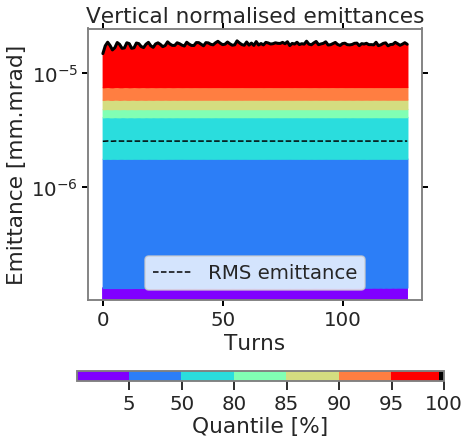

In [20]:
J_chosen_ids = [0, 9, 15, 16, 17, 18, 19]

NUM_COLORS = len(J_chosen_ids)
cm = plt.get_cmap('rainbow')

i_cgen = [cm(1.*i/float(NUM_COLORS - 1)) for i in range(NUM_COLORS)]

plt.figure(figsize=(6, 5))

last_J_idx = J_chosen_ids[0]
plt.fill_between(np.arange(len(rec_epsn_q_y)),
                 0,
                 rec_epsn_q_y[:, last_J_idx],
                 color=i_cgen[0])

for J_idx, col in zip(J_chosen_ids[1:], i_cgen[1:]):
    plt.fill_between(np.arange(len(rec_epsn_q_y)),
                     rec_epsn_q_y[:, last_J_idx],
                     rec_epsn_q_y[:, J_idx],
                     color=col)
    last_J_idx = J_idx

plt.plot(rec_epsn_q_y[:, last_J_idx], color='black')

plt.plot(rec_epsn_y, color='black', ls='--', lw=1.5, label='RMS emittance')
plt.legend(loc=8)

plt.yscale('log')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='none')

plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Vertical normalised emittances')

cmap = cm.from_list('Custom cmap', i_cgen, NUM_COLORS)
bounds = np.concatenate(([0], J_quantiles[J_chosen_ids]*100))
norm = mpl.colors.BoundaryNorm(bounds, NUM_COLORS)

ax2 = plt.gcf().add_axes([0.1, -0.1, 0.85, 0.03])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, #spacing='proportional', 
                               boundaries=bounds,
                               ticks=J_quantiles[J_chosen_ids]*100, orientation='horizontal')
cb.set_label('Quantile [%]')
ax2.axvline(1, color='black', lw=10)
plt.savefig('SIS100_with_PIC_SC_epsn_quantiles_y.png', dpi=150, bbox_inches='tight')